# Постановка задачи

Задача типа Time-to-Event / Survival с соревнований по DS https://ods.ai/competitions/data-fusion2024-churn

Необходимо решить задачу предсказания оттока клиентов банка. А именно, используя данные транзакций за 6 месяцев, требуется построить алгоритм, предсказывающий вероятность оттока клиента в следующие 6 месяцев. Особенностью задачи является то, что в рамках тренировочных данных для обучения, участникам передается не только метка, соответствующая тому, что клиент “уйдёт в отток”, но и время до его последней транзакции.

**--------Глоссарий-------**

**clients.csv** – базовая информация про клиентов:
+ user_id – ID клиента банка
+ report — номер одного из 12 отчетов, в который попал этот клиент
+ employee_count_nm – информация о работодателе клиента: число сотрудников в компании (осторожно, есть пропуски)
+ bankemplstatus – информация о том, является ли клиент сотрудников банка
+ customer_age – обфусцированный возраст клиента (до одной из 4 групп 0..3)


**train.csv** – тренировочные данные с целевой переменной про клиентов:
+ user_id – ID клиента банка
+ target – метка оттока клиента (целевой класс события оттока это 1)
+ time – через сколько дней случится последняя транзакция клиента (можно использовать как survival time в Time-to-Event анализе)


**report_dates.csv** – информация о датах отчетов:
+ report – порядковый номер отчета
+ report_dt — дата отчета 
 
 
**transactions.csv.zip**– архив с транзакциями клиентов банка:
+ user_id – ID клиента банка
+ mcc_code — mcc код транзакции
+ currency_rk – валюта транзакции
+ transaction_dttm – дата и время совершения операции
+ transaction_amt – сумма в валюте транзакции

# Подключение библиотек

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_log_error, r2_score, roc_auc_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn. preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostRegressor, CatBoostClassifier
from catboost import Pool, cv
from sksurv.ensemble import RandomSurvivalForest

sns.set_style("whitegrid")

# Функции и переменные 

In [4]:
RANDOM_STATE = 100
SPLIT_TEST_SIZE = 0.2 # размер тестовой выборки
NUM_SPLIT_FOR_GRID = 5 #на сколько частей будет разбиваться выборка при подборе параметров

# Загрузка данных

## Клиенты

In [5]:
clients_df = pd.read_csv('data/clients.csv')
clients_df.head()

,user_id,report,employee_count_nm,bankemplstatus,customer_age
0,3,2,ОТ 101 ДО 500,0,3
1,9,1,БОЛЕЕ 1001,0,3
2,13,6,ОТ 501 ДО 1000,0,2
3,37,5,БОЛЕЕ 1001,0,2
4,41,1,ОТ 101 ДО 500,0,2


In [6]:
clients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96000 entries, 0 to 95999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            96000 non-null  int64 
 1   report             96000 non-null  int64 
 2   employee_count_nm  59534 non-null  object
 3   bankemplstatus     96000 non-null  int64 
 4   customer_age       96000 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.7+ MB


In [7]:
print(f'Пользователи {"не" if clients_df.user_id.nunique() != len(clients_df) else ""}уникальны\n')
print('Распределение сотрудников банка к не сотрудникам: \n', clients_df.bankemplstatus.value_counts())

Пользователи уникальны

Распределение сотрудников банка к не сотрудникам: 
 bankemplstatus
0    95687
1      313
Name: count, dtype: int64


**Выводы**: 
+ наблюдаем большое кол-во null для колонки employee_count_nm. Возможно, стоит проверить взаимосвязь данного признака с другими(например, возраст) и по ним сделать прогноз для отсутствующих значений.
+ в данных большой перевес среди не сотрудников банка, а этот признак должен играть существенную роль, ведь если клиент является сотрудником, то шансов уйти меньше


## Транзакции

In [8]:
trans_df = pd.read_csv('data/transactions.csv')
trans_df.head()

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,3,3,1,-183.883957,2022-01-28 12:05:33
1,3,3,1,-3206.437012,2022-01-28 12:52:30
2,3,16,1,-153866.890625,2022-02-16 14:45:56
3,3,56,1,-15144.601562,2022-03-09 19:58:29
4,3,0,1,5297.908691,2022-03-12 18:11:31


In [9]:
trans_df.mcc_code.value_counts()

mcc_code
1      4152654
2      1065363
4       947720
3       719400
0       582177
        ...   
449          1
314          1
243          1
323          1
273          1
Name: count, Length: 332, dtype: int64

In [10]:
trans_df['transaction_dttm'] = pd.to_datetime(trans_df['transaction_dttm'])

In [11]:
trans_df.currency_rk.value_counts()

currency_rk
1    12701022
0      370455
3        1795
2        1751
Name: count, dtype: int64

In [12]:
trans_df.mcc_code.nunique()

332

загрузим связанный с данным фреймом фрейм с описанием кодов mcc

In [13]:
mcc_df = pd.read_csv('data/mcc_codes.csv')
mcc_df.head()

,MCC,Название,Описание
0,742,Ветеринарные услуги,Лицензированные специалисты в основном занимаю...
1,763,Сельскохозяйственные кооперативы,"Ассоциации и кооперативы, которые предоставляю..."
2,780,Услуги садоводства и ландшафтного дизайна,Ландшафтные архитекторы и другие поставщики ус...
3,1520,Генеральные подрядчики – жилое и коммерческое ...,"Генеральные подрядчики, в основном занимающиес..."
4,1711,"Генеральные подрядчики по вентиляции, теплосна...","Специальные торговые подрядчики, которые работ..."


In [14]:
mcc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385 entries, 0 to 384
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   MCC       385 non-null    int64 
 1   Название  385 non-null    object
 2   Описание  290 non-null    object
dtypes: int64(1), object(2)
memory usage: 9.2+ KB


**Выводы:**
+ среди валют есть одна ярко выраженная группа, а так же две группы, представленные довольно редко. Возможно, имеет смысл попробовать ввести следующие признаки: оставить только расчет отдельно по двум преобладающим группам, а из остальных сформировать признаки пользуется пользователь данной валютой либо нет
+ mcc_code в фрейме с транзакциями не несет никакой смысловой нагрузки, мы не можем определить что кроется за конкретным значением, но мы видим сильно частую категорию транзакций, возможно, что под ней кроются товары первой необходимости

## Отчеты

In [15]:
report_df = pd.read_csv('data/report_dates.csv')
report_df.head()

,report,report_dt
0,1,2022-07-31 03:00:00
1,2,2022-08-31 03:00:00
2,3,2022-09-30 03:00:00
3,4,2022-10-31 03:00:00
4,5,2022-11-30 03:00:00


In [16]:
report_df['report_dt'] = pd.to_datetime(report_df['report_dt'])

**Выводы:**
+ Будем использовать данный фрейм для проверки не попали ли какие данные о транзакциях пользователя уже после формирования отчета о нем

## Тренировочная выборка

In [17]:
train_df = pd.read_csv('data/train.csv')
train_df.head()

,user_id,target,time
0,3,0,77
1,13,0,86
2,37,0,89
3,41,0,57
4,42,0,84


In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  64000 non-null  int64
 1   target   64000 non-null  int64
 2   time     64000 non-null  int64
dtypes: int64(3)
memory usage: 1.5 MB


# Анализ целевой переменной

In [19]:
print('Максимальное время жизни для всех пользователей:', train_df['time'].max())
print('максимальное время жизни для пользователей, ушедших в отток:', 
      train_df[train_df['target'] == 1]['time'].max())

Максимальное время жизни для всех пользователей: 91
максимальное время жизни для пользователей, ушедших в отток: 91


посмотрим на графики времени жизни для ушедших в отток и не ушедших

/home/habibis/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/habibis/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


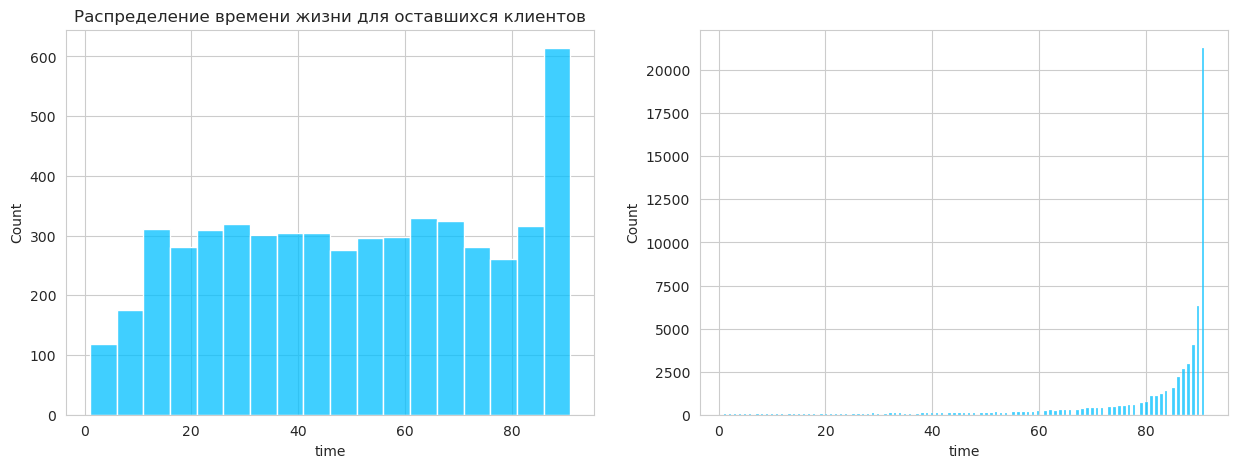

In [20]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.histplot(data=train_df[train_df['target'] == 1], x='time', ax=axis[0], color="deepskyblue")
axis[0].set_title('Распределение времени жизни для ушедших в отток')
sns.histplot(data=train_df[train_df['target'] == 0], x='time', ax=axis[1], color="deepskyblue")
axis[0].set_title('Распределение времени жизни для оставшихся клиентов');


построим график целевой переменной target

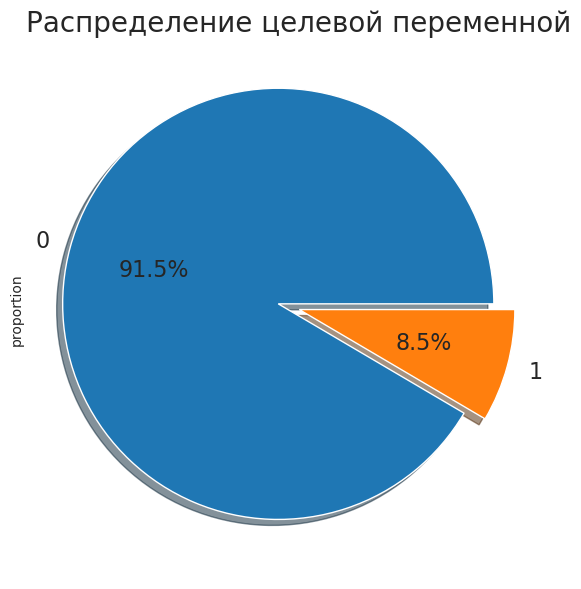

In [21]:
plt.figure(figsize=(7,7))
train_df.target.value_counts(normalize=True).plot.pie(explode=[0.1,0.001], autopct='%1.1f%%', shadow=True, 
                                        textprops={'fontsize':16}).set_title('Распределение целевой переменной', fontsize=20);

**Выводы:**
+ Максимальное время отображает кол-во дней за 3 мес. По графикам можно заметить, что для клиентов, которые ушли, распределение более равномерное по времени, в отличие от оставшихся клиентов. По последним наоборот малое значение времени встречается редко (возможно, человек уезжал в командировку/отпуск и долгое время не пользовался услугами банка, после чего возвращался) 
+ Данные по целевой имеют очень большой дисбаланс, обязательно везде используем стратификацию

# Проверка корректности данных

прежде всего проверим, что все приведенные транзации в трейн идут до формирования статуса

In [22]:
cl_rep_short_df = clients_df.merge(report_df, on='report')[['user_id', 'report_dt']]
# для тейн выборки используются даты от <t_отчета - 9 мес> до <t_отчета - 3 мес> 
cl_rep_short_df['min_dt_train'] = cl_rep_short_df['report_dt'] - pd.to_timedelta('277 day')
cl_rep_short_df['max_dt_train'] = cl_rep_short_df['report_dt'] - pd.to_timedelta('91 day')
cl_rep_short_df.head()

,user_id,report_dt,min_dt_train,max_dt_train
0,3,2022-08-31 03:00:00,2021-11-27 03:00:00,2022-06-01 03:00:00
1,90,2022-08-31 03:00:00,2021-11-27 03:00:00,2022-06-01 03:00:00
2,146,2022-08-31 03:00:00,2021-11-27 03:00:00,2022-06-01 03:00:00
3,275,2022-08-31 03:00:00,2021-11-27 03:00:00,2022-06-01 03:00:00
4,572,2022-08-31 03:00:00,2021-11-27 03:00:00,2022-06-01 03:00:00


In [23]:
# соединим фрейм с транзакционным
cl_rep_trans_df = cl_rep_short_df.merge(trans_df, on='user_id')
cl_rep_trans_df.head()

,user_id,report_dt,min_dt_train,max_dt_train,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,3,2022-08-31 03:00:00,2021-11-27 03:00:00,2022-06-01 03:00:00,3,1,-183.883957,2022-01-28 12:05:33
1,3,2022-08-31 03:00:00,2021-11-27 03:00:00,2022-06-01 03:00:00,3,1,-3206.437012,2022-01-28 12:52:30
2,3,2022-08-31 03:00:00,2021-11-27 03:00:00,2022-06-01 03:00:00,16,1,-153866.890625,2022-02-16 14:45:56
3,3,2022-08-31 03:00:00,2021-11-27 03:00:00,2022-06-01 03:00:00,56,1,-15144.601562,2022-03-09 19:58:29
4,3,2022-08-31 03:00:00,2021-11-27 03:00:00,2022-06-01 03:00:00,0,1,5297.908691,2022-03-12 18:11:31


In [24]:
del trans_df

In [25]:
# проверим есть ли у нас транзации, осуществленные позже времени, заложенного на трейн
cl_rep_trans_df[cl_rep_trans_df['transaction_dttm'] > cl_rep_trans_df['max_dt_train']]

,user_id,report_dt,min_dt_train,max_dt_train,mcc_code,currency_rk,transaction_amt,transaction_dttm


In [26]:
early_users = cl_rep_trans_df[cl_rep_trans_df['transaction_dttm'] < cl_rep_trans_df['min_dt_train']].user_id.unique()
print(early_users, 'Всего клиентов с ранней историей =', len(early_users), 'из', len(clients_df))


[    90    146    572 ... 549144 549328 549549] Всего клиентов с ранней историей = 67795 из 96000


In [27]:
# посмотрим какие данные в результате для обнаруженных клиентов
train_df[train_df['user_id'].isin(early_users)].target.value_counts()

target
0    41781
1     3470
Name: count, dtype: int64

In [28]:
# проверим, что по для всех клиентов есть транзакции в указанное "окно"
cl_rep_trans_df[(cl_rep_trans_df.user_id.isin(early_users)) 
                & (cl_rep_trans_df.transaction_dttm > cl_rep_trans_df.min_dt_train)].user_id.nunique()

67795

**Выводы:**
Самое главное, что у нас нет данных более поздних, чем нужны, т.е. тех, которые мы еще не должны знать для прогнозов. При этом у нас есть для большого числа пользователей транзакции, проведенные раннее тренировочной выборки. Для всех таких клиентов так же для имеются транзации, совершенные в корректное время. Мы не будем удалять ранние транзакции, просто, всегда будем брать именно относительные величины по ним, а не абсолютные

In [29]:
trans_df = cl_rep_trans_df.drop(columns=['report_dt', 'min_dt_train', 'max_dt_train'])
trans_df.head()

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,3,3,1,-183.883957,2022-01-28 12:05:33
1,3,3,1,-3206.437012,2022-01-28 12:52:30
2,3,16,1,-153866.890625,2022-02-16 14:45:56
3,3,56,1,-15144.601562,2022-03-09 19:58:29
4,3,0,1,5297.908691,2022-03-12 18:11:31


In [30]:
del cl_rep_trans_df

# Feature Engineering

## Признаки из фрейма с транзакциями

+ разнообразие категорий товаров
+ признак - самая популярная группа категорий, категориальная
+ частота транзакций в день в среднем
+ линейная регрессия по кол-ву транзакций в день - коеффициент перед параметром даты (индекса при сортировке по дате)
+ пользуется ли "редкой" валютой
+ "остаток" по счетам в разных валютах
+ сколько дней с начала трейн до первой транзакции
+ сколько дней с окончания трейн до последней транзакции

**разнообразие различных категорий товаров у пользователя** (Предположение: чем разнообразней - тем меньше вероятности, что пользователь уйдет в отток) 

In [31]:
df_user_f1 = trans_df.groupby(['user_id']).mcc_code.nunique().rename('number_different_mcc').reset_index()
df_user_f1.head()

,user_id,number_different_mcc
0,3,4
1,9,22
2,13,4
3,37,28
4,41,5


**самая популярная категория**

In [32]:
df_user_f2 = trans_df.groupby(['user_id']).mcc_code.value_counts().rename('counts').reset_index().drop_duplicates('user_id')
df_user_f2.head()

,user_id,mcc_code,counts
0,3,0,7
4,9,1,27
26,13,3,14
30,37,2,129
58,41,3,6


**посмотрим на самые популярные mcc у ушедших клиентов и оставшихся**

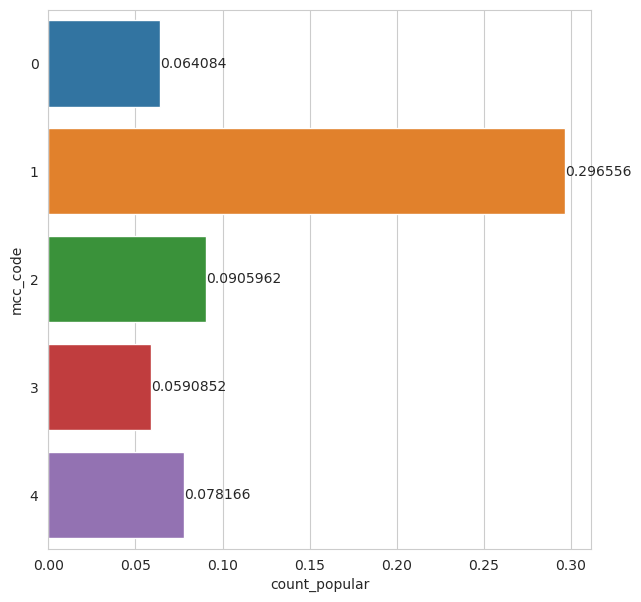

In [33]:
plt.figure(figsize=(7,7))
df_mcc_ch = trans_df[trans_df.user_id.isin(train_df[train_df['target'] == 1].user_id.tolist())]\
    .mcc_code.value_counts(normalize=True)\
    .rename('count_popular')\
    .iloc[:5].sort_index().reset_index()
ax = sns.barplot(data=df_mcc_ch, x='count_popular', y='mcc_code', orient = 'h');   
ax.bar_label(ax.containers[0]);

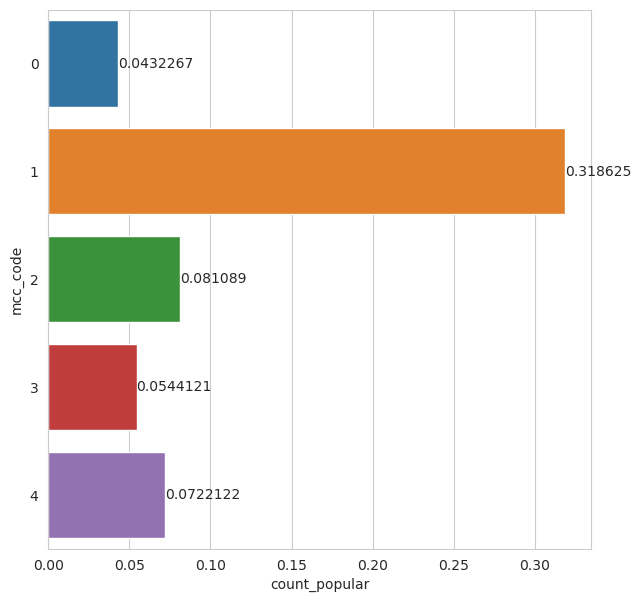

In [34]:
plt.figure(figsize=(7,7))
# сначала отберем топ 10 самых популярных mcc среди ушедших и нет клиентов
df_mcc_not_ch = trans_df[trans_df.user_id.isin(train_df[train_df['target'] == 0].user_id.tolist())]\
    .mcc_code.value_counts(normalize=True)\
    .rename('count_popular').sort_index().reset_index().iloc[:5]
ax = sns.barplot(data=df_mcc_not_ch, x='count_popular', y='mcc_code', orient = 'h');   
ax.bar_label(ax.containers[0]);

Видим, что отношение самых популярных mcc кодов одинаково среди ушедших клиентов и среди оставшихся, нам значение категории mcc вряд ли поможет с классификацией, поэтому целесообразность ввода вышеприведенного признака с самым популярных mcc вызыввает вопросы

**кол-во дней с транзакциями**

In [35]:
trans_df['transaction_dt'] = pd.to_datetime(trans_df.transaction_dttm.dt.date)


In [36]:
df_user_f3 = trans_df.groupby(['user_id']).transaction_dt.nunique().rename('number_different_date').reset_index()
df_user_f3.head()

,user_id,number_different_date
0,3,8
1,9,54
2,13,18
3,37,129
4,41,12


**кол-во дней между последней транзакцией и завершением времени трейн**

In [37]:
user_max_trans_df = trans_df.groupby(['user_id']).transaction_dt.max().rename('transaction_dt_max').reset_index()
user_max_trans_df['transaction_dt_max'] = pd.to_datetime(user_max_trans_df['transaction_dt_max'] )
user_max_trans_df.head()

,user_id,transaction_dt_max
0,3,2022-05-14
1,9,2022-04-19
2,13,2022-09-07
3,37,2022-08-17
4,41,2022-04-18


In [38]:
df_temp = user_max_trans_df.merge(cl_rep_short_df, on='user_id')
df_temp['days_between_last_and_trans'] = (df_temp['max_dt_train'] - df_temp['transaction_dt_max']).dt.days
df_user_f4 = df_temp[['user_id', 'days_between_last_and_trans']]
del df_temp, user_max_trans_df
df_user_f4.head()

,user_id,days_between_last_and_trans
0,3,18
1,9,12
2,13,24
3,37,14
4,41,13


In [39]:
df_user_f4['days_between_last_and_trans'].min()

11

Почему то у нас минимально возможное число - 11 дней, проверим для произвольного пользователя с довольно частыми транзакциями, что это действительно так

In [40]:
#trans_df[trans_df['transaction_dt'] == trans_df.transaction_dt.max()].user_id
trans_df[trans_df.user_id == 94].sort_values(by='transaction_dt', ascending=False)

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,transaction_dt
4367699,94,10,1,-1187.647583,2023-03-20 08:01:26,2023-03-20
4367698,94,4,1,-3016.642822,2023-03-18 12:51:06,2023-03-18
4367697,94,1,1,-92.889709,2023-03-18 12:12:05,2023-03-18
4367696,94,32,1,-134.797424,2023-03-18 09:16:12,2023-03-18
4367695,94,1,1,-569.819153,2023-03-18 08:55:19,2023-03-18
...,...,...,...,...,...,...
4367193,94,1,1,-1153.897461,2022-09-21 02:51:33,2022-09-21
4367191,94,4,1,-861.282227,2022-09-21 00:49:55,2022-09-21
4367195,94,1,1,-1077.387207,2022-09-21 04:54:47,2022-09-21
4367196,94,86,1,-724.334961,2022-09-21 08:28:55,2022-09-21


In [41]:
cl_rep_short_df[cl_rep_short_df.user_id == 94]

,user_id,report_dt,min_dt_train,max_dt_train
31078,94,2023-06-30 03:00:00,2022-09-26 03:00:00,2023-03-31 03:00:00


да, разница действительно 11 дней для рассматриваемого пользователя, не смотря на то, что транзакции совершаются раз в несколько дней

**доля транзакций в российской валюте по отношению ко всем транзакциям пользователя**

In [42]:
trans_df.head()

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,transaction_dt
0,3,3,1,-183.883957,2022-01-28 12:05:33,2022-01-28
1,3,3,1,-3206.437012,2022-01-28 12:52:30,2022-01-28
2,3,16,1,-153866.890625,2022-02-16 14:45:56,2022-02-16
3,3,56,1,-15144.601562,2022-03-09 19:58:29,2022-03-09
4,3,0,1,5297.908691,2022-03-12 18:11:31,2022-03-12


In [43]:
trans_count_for_users_df = trans_df.groupby('user_id').currency_rk\
                              .value_counts(normalize=True).rename('number_trans').reset_index()
trans_count_for_users_df.head()

,user_id,currency_rk,number_trans
0,3,1,1.000000
1,9,1,1.000000
2,13,1,0.954545
3,13,0,0.045455
4,37,1,1.000000


In [44]:
df_user_f5 = trans_count_for_users_df[trans_count_for_users_df['currency_rk'] == 1][['user_id', 'number_trans']]
df_user_f5.rename(columns={"number_trans": "number_trans_rub"}, inplace=True)
df_user_f5.head()

,user_id,number_trans_rub
0,3,1.000000
1,9,1.000000
2,13,0.954545
4,37,1.000000
5,41,1.000000


In [45]:
df_user_f5

,user_id,number_trans_rub
0,3,1.000000
1,9,1.000000
2,13,0.954545
4,37,1.000000
5,41,1.000000
...,...,...
107330,562043,1.000000
107331,562205,1.000000
107332,562312,1.000000
107333,562721,1.000000


**абсолютный оборот по каждой из валют**

In [46]:
def logsumabs(x):
    return (np.log(x.abs().sum()))

temp_trans = trans_df.groupby(['user_id','currency_rk'])['transaction_amt'].agg([logsumabs])
temp_trans.head()

logsumabs
user_id currency_rk           
3       1            12.789712
9       1            12.686752
13      0             9.284780
        1            12.825245
37      1            12.775178

In [47]:
trans_sum = temp_trans.unstack('currency_rk').fillna(0)#.reset_index()
trans_sum.head()

logsumabs                     
currency_rk         0          1    2    3
user_id                                   
3             0.00000  12.789712  0.0  0.0
9             0.00000  12.686752  0.0  0.0
13            9.28478  12.825245  0.0  0.0
37            0.00000  12.775178  0.0  0.0
41            0.00000  11.595303  0.0  0.0

In [48]:
trans_sum.columns = ['log_sum_amt_abs_0','log_sum_amt_abs_1','log_sum_amt_abs_2','log_sum_amt_abs_3']
trans_sum.reset_index(inplace=True)
trans_sum.head()

,user_id,log_sum_amt_abs_0,log_sum_amt_abs_1,log_sum_amt_abs_2,log_sum_amt_abs_3
0,3,0.00000,12.789712,0.0,0.0
1,9,0.00000,12.686752,0.0,0.0
2,13,9.28478,12.825245,0.0,0.0
3,37,0.00000,12.775178,0.0,0.0
4,41,0.00000,11.595303,0.0,0.0


**значение коеффициента для долей транзакций с разбивкой по неделям**


Общий принцип построения признака: считаем, что если число транзакций падает со сглаживанием по неделям, шанс на уход клиента растет. Причем важность роста/падения числа транзакций с течением времени растет по экспоненциальному закону

In [49]:
# создадим экспоненциально увеличивающиеся весы
f = np.arange(0, 26)
#df = pd.DataFrame({'B': (f/f.sum())})
#df = pd.DataFrame({'B': f})
#exp_weights = df.ewm(alpha=0.1).mean()
#exp_weights.head()
df = pd.DataFrame({'weight': f * np.exp(-f/26)})
df

,weight
0,0.000000
1,0.962269
2,1.851922
3,2.673070
4,3.429616
5,4.125265
6,4.763536
7,5.347769
8,5.881132
9,6.366633


In [50]:
# для каждого пользователя выбираем уникальные даты транзакций
trans_dt_for_user_df = trans_df.drop_duplicates(subset=['user_id', 'transaction_dt'])[['user_id', 'transaction_dt']]
trans_dt_for_user_df.head()

,user_id,transaction_dt
0,3,2022-01-28
2,3,2022-02-16
3,3,2022-03-09
4,3,2022-03-12
5,3,2022-04-11


In [51]:
# оставляем только нужные колонки
cl_rep_short_df_only_min = cl_rep_short_df[['user_id', 'min_dt_train']]
cl_rep_short_df_only_min['min_date_train'] = pd.to_datetime(cl_rep_short_df_only_min['min_dt_train'].dt.date)
del cl_rep_short_df_only_min['min_dt_train']
cl_rep_short_df_only_min.head()

/tmp/ipykernel_16686/867352534.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cl_rep_short_df_only_min['min_date_train'] = pd.to_datetime(cl_rep_short_df_only_min['min_dt_train'].dt.date)


,user_id,min_date_train
0,3,2021-11-27
1,90,2021-11-27
2,146,2021-11-27
3,275,2021-11-27
4,572,2021-11-27


In [52]:
# у нас некоторые наблюдения были раньше, чем вычислилось min_date_train - сейчас неободимо их удалить
df_temp = trans_dt_for_user_df.merge(cl_rep_short_df_only_min, on='user_id')
del trans_dt_for_user_df, cl_rep_short_df_only_min
df_temp = df_temp[df_temp.transaction_dt >= df_temp.min_date_train]

In [53]:
df_temp['min_date_train']

0         2021-11-27
1         2021-11-27
2         2021-11-27
3         2021-11-27
4         2021-11-27
             ...    
5601163   2022-04-29
5601164   2022-04-29
5601165   2022-04-29
5601166   2022-04-29
5601167   2022-04-29
Name: min_date_train, Length: 5385456, dtype: datetime64[ns]

In [54]:
# выберем число дней от начала трейн до транзакции
df_temp['days_between_first_dt_and_trans_dt'] = (df_temp['transaction_dt'] - df_temp['min_date_train']).dt.days
df_temp.head()

,user_id,transaction_dt,min_date_train,days_between_first_dt_and_trans_dt
0,3,2022-01-28,2021-11-27,62
1,3,2022-02-16,2021-11-27,81
2,3,2022-03-09,2021-11-27,102
3,3,2022-03-12,2021-11-27,105
4,3,2022-04-11,2021-11-27,135


In [55]:
del df_temp['transaction_dt'], df_temp['min_date_train']

In [56]:
# получим значение "недели" 
df_temp['weeks_between_first_dt_and_trans_dt'] = df_temp['days_between_first_dt_and_trans_dt']/7
df_temp['weeks_between_first_dt_and_trans_dt'] = df_temp['weeks_between_first_dt_and_trans_dt'].astype(int)
del df_temp['days_between_first_dt_and_trans_dt']

In [57]:
# посчитаем кол-во транзакций по неделям для каждого клиента
df_temp = df_temp.groupby(['user_id', 'weeks_between_first_dt_and_trans_dt']).size().rename('number_trans_in_week').reset_index()
df_temp.head()

,user_id,weeks_between_first_dt_and_trans_dt,number_trans_in_week
0,3,8,1
1,3,11,1
2,3,14,1
3,3,15,1
4,3,19,1


In [58]:
print('МАксимальное число недель в трейн =', df_temp.weeks_between_first_dt_and_trans_dt.max() + 1)

МАксимальное число недель в трейн = 26


In [59]:
# так же нам нужно добавить недостащие недели, в теч которых у клиента не было транзакций
# для этого сформируем вспомогательный датафрейм со всеми неделями для всех клиентов
count_weeks = 26
week_list = np.arange(count_weeks)
l = ([i for i in range(count_weeks)] * df_temp.user_id.nunique())
l.sort()
df_add = pd.DataFrame({'user_id':list(df_temp.user_id.unique()) * count_weeks, 'weeks_between_first_dt_and_trans_dt': l})
df_temp = df_temp.merge(df_add, on=['user_id','weeks_between_first_dt_and_trans_dt'], how='outer')
df_temp['number_trans_in_week'].fillna(0, inplace=True)
df_temp.head()

,user_id,weeks_between_first_dt_and_trans_dt,number_trans_in_week
0,3,8,1.0
1,3,11,1.0
2,3,14,1.0
3,3,15,1.0
4,3,19,1.0


In [60]:
# просто проверим, что для случайного пользователя сформировались значения по всем неделям
df_temp[df_temp.user_id == 3].sort_values('weeks_between_first_dt_and_trans_dt')

,user_id,weeks_between_first_dt_and_trans_dt,number_trans_in_week
1715707,3,0,0.0
1744297,3,1,0.0
1775608,3,2,0.0
1802136,3,3,0.0
1830313,3,4,0.0
1858122,3,5,0.0
1889588,3,6,0.0
1916889,3,7,0.0
0,3,8,1.0
1972224,3,9,0.0


In [61]:
# теперь посчитаем lag по одной неделе
df_temp['last'] = df_temp.groupby('user_id').number_trans_in_week.shift(periods=1)
df_temp.fillna(0,inplace=True)
df_temp['diff_last_week'] = df_temp['number_trans_in_week'] - df_temp['last']



In [62]:
# посчитаем коммулятивную сумму по разностям
#df_temp['cumsum_diff_trans'] = df_temp.sort_values('weeks_between_first_dt_and_trans_dt')\
#                                      .groupby('user_id').diff_last_week.cumsum()

In [63]:
df_temp

,user_id,weeks_between_first_dt_and_trans_dt,number_trans_in_week,last,diff_last_week
0,3,8,1.0,0.0,1.0
1,3,11,1.0,1.0,0.0
2,3,14,1.0,1.0,0.0
3,3,15,1.0,1.0,0.0
4,3,19,1.0,1.0,0.0
...,...,...,...,...,...
2495995,561824,25,0.0,0.0,0.0
2495996,561895,25,0.0,0.0,0.0
2495997,562043,25,0.0,0.0,0.0
2495998,562312,25,0.0,0.0,0.0


In [64]:
# вводим колонку с весами
f = np.arange(0, count_weeks)
# создаем второстепенный дф
df_w = pd.DataFrame({'weight': f * np.exp(-f/26)})
df_w = df_w.reset_index()
df_w.columns = ['weeks_between_first_dt_and_trans_dt', 'weight']
#exp_weights = df_w.ewm(alpha=0.1).mean()
#exp_weights = exp_weights.reset_index()
#exp_weights.columns = ['weeks_between_first_dt_and_trans_dt', 'weight']

# соединяем и считаем результирующее значение для каждого пользователя
df_temp = df_temp.merge(df_w, on='weeks_between_first_dt_and_trans_dt')
df_temp['diff_trans_w'] =df_temp['diff_last_week'] * df_temp['weight']
df_user_f6 = df_temp.groupby('user_id').diff_trans_w.sum().rename('sum_diff_week_trans').reset_index()
df_user_f6.head()

,user_id,sum_diff_week_trans
0,3,5.881132
1,9,-16.424233
2,13,-4.151093
3,37,-47.164477
4,41,9.039196


**частота нулевых транзакций по неделям(используя предыдущие наработки)**

In [65]:
def frequency_zero_diff(val):
    return (val == 0).sum()/len(val)

df_user_f7 = df_temp.groupby('user_id').number_trans_in_week.agg([frequency_zero_diff]).reset_index()
df_user_f7.head()

,user_id,frequency_zero_diff
0,3,0.692308
1,9,0.269231
2,13,0.500000
3,37,0.038462
4,41,0.692308


**посчитаем взвешенное кол-во нулевых транзакций по неделям**

In [66]:
df_temp['zero_num_trans'] = (df_temp['number_trans_in_week'] == 0).astype(int)
df_temp['zero_num_trans_w'] = df_temp['zero_num_trans'] * df_temp['weight']
df_temp.head()

,user_id,weeks_between_first_dt_and_trans_dt,number_trans_in_week,last,diff_last_week,weight,diff_trans_w,zero_num_trans,zero_num_trans_w
0,3,8,1.0,0.0,1.0,5.881132,5.881132,0,0.0
1,9,8,1.0,4.0,-3.0,5.881132,-17.643396,0,0.0
2,37,8,7.0,4.0,3.0,5.881132,17.643396,0,0.0
3,42,8,1.0,1.0,0.0,5.881132,0.000000,0,0.0
4,46,8,7.0,7.0,0.0,5.881132,0.000000,0,0.0


In [67]:
df_temp[df_temp['user_id'] == 3].sort_values('weeks_between_first_dt_and_trans_dt')

,user_id,weeks_between_first_dt_and_trans_dt,number_trans_in_week,last,diff_last_week,weight,diff_trans_w,zero_num_trans,zero_num_trans_w
835410,3,0,0.0,1.0,-1.0,0.000000,-0.000000,1,0.000000
928689,3,1,0.0,0.0,0.0,0.962269,0.000000,1,0.962269
1029472,3,2,0.0,0.0,0.0,1.851922,0.000000,1,1.851922
2083823,3,3,0.0,0.0,0.0,2.673070,0.000000,1,2.673070
1124191,3,4,0.0,0.0,0.0,3.429616,0.000000,1,3.429616
1216534,3,5,0.0,0.0,0.0,4.125265,0.000000,1,4.125265
1316699,3,6,0.0,0.0,0.0,4.763536,0.000000,1,4.763536
1412593,3,7,0.0,0.0,0.0,5.347769,0.000000,1,5.347769
0,3,8,1.0,0.0,1.0,5.881132,5.881132,0,0.000000
1506425,3,9,0.0,0.0,0.0,6.366633,0.000000,1,6.366633


In [68]:
df_user_f8 = df_temp.groupby('user_id').zero_num_trans_w.sum().rename('sum_zero_num_trans_w').reset_index()
df_user_f8.head()

,user_id,sum_zero_num_trans_w
0,3,106.592128
1,9,57.214657
2,13,95.149619
3,37,9.557607
4,41,115.918729


## Признаки фрейма с отчетами

**месяц отчета**

In [69]:
# выбираем месяц отчета
report_df['report_month'] = report_df.report_dt.dt.month
# время отчета так же добавим. Оно нам не понадобится для моделирования, но пригодится для построения стат base model
clients_df = clients_df.merge(report_df[['report', 'report_month', 'report_dt']], on='report')

In [70]:
clients_df.head()

,user_id,report,employee_count_nm,bankemplstatus,customer_age,report_month,report_dt
0,3,2,ОТ 101 ДО 500,0,3,8,2022-08-31 03:00:00
1,90,2,ОТ 101 ДО 500,0,3,8,2022-08-31 03:00:00
2,146,2,ОТ 51 ДО 100,0,2,8,2022-08-31 03:00:00
3,275,2,ОТ 101 ДО 500,0,2,8,2022-08-31 03:00:00
4,572,2,NaN,0,2,8,2022-08-31 03:00:00


## Признаки фрейма с клиентами

**анализ bankemplstatus**

посмотрим есть ли и сколько ушедших сотрудников банка

In [71]:
train_df

,user_id,target,time
0,3,0,77
1,13,0,86
2,37,0,89
3,41,0,57
4,42,0,84
...,...,...,...
63995,561824,0,91
63996,562043,0,75
63997,562312,0,91
63998,562721,0,29


In [72]:
temp_cl_df = clients_df.merge(train_df[['user_id', 'target']], on='user_id')
temp_cl_df[(temp_cl_df['bankemplstatus'] == 1) & (temp_cl_df['target'] == 1)]

,user_id,report,employee_count_nm,bankemplstatus,customer_age,report_month,report_dt,target
51297,343868,9,ОТ 11 ДО 30,1,0,3,2023-03-31 03:00:00,1


In [73]:
(temp_cl_df['bankemplstatus'] == 1).sum()

206

только один сотрудник банка ушел в отток, т.е. если bankemplstatus = 1, практически 100%, что клиент не уйдет в отток, очень инфлормативный признак для модели

**анализ employee_count_nm**

In [74]:
clients_df['employee_count_nm'].isna().sum()/len(clients_df)

0.37985416666666666

почти 38% значений пропущено, довольно много, посмотрим, как распределяются значения целевой в зависимости от данного признака

In [75]:
temp_cl_df = clients_df.merge(train_df[['user_id', 'target']], on='user_id')
temp_cl_df.head()

,user_id,report,employee_count_nm,bankemplstatus,customer_age,report_month,report_dt,target
0,3,2,ОТ 101 ДО 500,0,3,8,2022-08-31 03:00:00,0
1,90,2,ОТ 101 ДО 500,0,3,8,2022-08-31 03:00:00,0
2,146,2,ОТ 51 ДО 100,0,2,8,2022-08-31 03:00:00,0
3,275,2,ОТ 101 ДО 500,0,2,8,2022-08-31 03:00:00,0
4,714,2,ОТ 501 ДО 1000,0,3,8,2022-08-31 03:00:00,0


In [76]:
clients_df['employee_count_nm'].value_counts()

employee_count_nm
БОЛЕЕ 1001        17833
ОТ 101 ДО 500     14362
ОТ 51 ДО 100       7314
ОТ 501 ДО 1000     6481
ОТ 11 ДО 50        4413
ДО 10              3797
БОЛЕЕ 500          1996
ОТ 11 ДО 30        1871
ОТ 31 ДО 50        1467
Name: count, dtype: int64

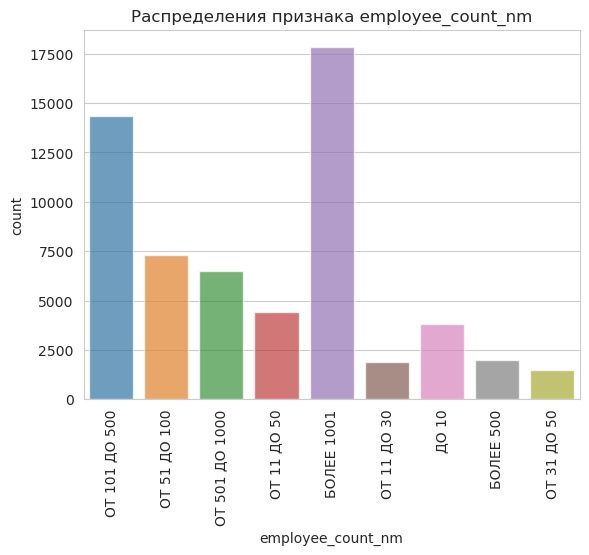

In [77]:
sns.countplot(data=clients_df, x='employee_count_nm', alpha=0.7)
plt.xticks(rotation=90) 
plt.title('Распределения признака employee_count_nm');

In [78]:
temp_cl_df.groupby('employee_count_nm')['target'].value_counts(normalize=True)

employee_count_nm  target
БОЛЕЕ 1001         0         0.958859
                   1         0.041141
БОЛЕЕ 500          0         0.962935
                   1         0.037065
ДО 10              0         0.928407
                   1         0.071593
ОТ 101 ДО 500      0         0.945089
                   1         0.054911
ОТ 11 ДО 30        0         0.929739
                   1         0.070261
ОТ 11 ДО 50        0         0.934923
                   1         0.065077
ОТ 31 ДО 50        0         0.918641
                   1         0.081359
ОТ 501 ДО 1000     0         0.953323
                   1         0.046677
ОТ 51 ДО 100       0         0.943461
                   1         0.056539
Name: proportion, dtype: float64

In [79]:
temp_cl_df.info()
temp_cl_df['target'] = temp_cl_df['target'].astype(str)
temp_cl_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            64000 non-null  int64         
 1   report             64000 non-null  int64         
 2   employee_count_nm  39777 non-null  object        
 3   bankemplstatus     64000 non-null  int64         
 4   customer_age       64000 non-null  int64         
 5   report_month       64000 non-null  int32         
 6   report_dt          64000 non-null  datetime64[ns]
 7   target             64000 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(5), object(1)
memory usage: 3.7+ MB


,user_id,report,employee_count_nm,bankemplstatus,customer_age,report_month,report_dt,target
0,3,2,ОТ 101 ДО 500,0,3,8,2022-08-31 03:00:00,0
1,90,2,ОТ 101 ДО 500,0,3,8,2022-08-31 03:00:00,0
2,146,2,ОТ 51 ДО 100,0,2,8,2022-08-31 03:00:00,0
3,275,2,ОТ 101 ДО 500,0,2,8,2022-08-31 03:00:00,0
4,714,2,ОТ 501 ДО 1000,0,3,8,2022-08-31 03:00:00,0
...,...,...,...,...,...,...,...,...
63995,548730,7,ДО 10,0,0,1,2023-01-31 03:00:00,1
63996,548765,7,NaN,0,0,1,2023-01-31 03:00:00,0
63997,548879,7,NaN,0,2,1,2023-01-31 03:00:00,0
63998,549160,7,NaN,0,1,1,2023-01-31 03:00:00,0


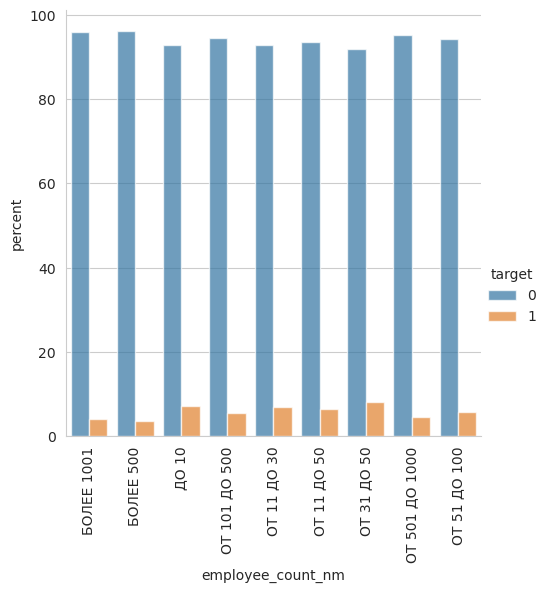

In [80]:
#plt.xticks(rotation=90)
#sns.countplot(data=temp_cl_df, x='employee_count_nm', hue='target', alpha=0.7)

temp_cl_df_per = (temp_cl_df
.groupby('employee_count_nm')['target']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
)
#.pipe((sns.catplot,'data'), x='employee_count_nm',y='percent',hue='target',kind='bar'))
#plt.xticks(rotation=90) 
sns.catplot(data=temp_cl_df_per, x='employee_count_nm', y='percent', hue='target', kind='bar', alpha=0.7)
plt.xticks(rotation=90); 

зависимость целевой от employee_count_nm прослеживается. Например, можем заметить, что при численности до 10 довольно большой процент ушедших клиентов. Нужно постараться восстановить значения, либо попробовать сделать прогноз только по имеющимся данным, затем без данного признака(т.к. все же критично большое число наблюдений удаляется при чистке по nan), сравнить результаты

Более 500 и более 1001, а так же от 501 до 1000 можно объединить в одно значение. аналогично для признаков от 11 до 30 и от 11 до 50 и от 31 до 50. Т.е. оставим 5 категории: до 10, от 11 до 50, от 51 до 100, от 101 до 500, от 501 

Произведем замену значений:

In [81]:
dict_for_repl = {'ДО 10': 0, 'ОТ 51 ДО 100': 2, 'ОТ 101 ДО 500': 3}
dict_for_repl.update(dict.fromkeys(['ОТ 501 ДО 1000', 'БОЛЕЕ 500', 'БОЛЕЕ 1001'], 4))
dict_for_repl.update(dict.fromkeys(['ОТ 11 ДО 30','ОТ 11 ДО 50','ОТ 31 ДО 50'], 1))
dict_for_repl

{'ДО 10': 0,
 'ОТ 51 ДО 100': 2,
 'ОТ 101 ДО 500': 3,
 'ОТ 501 ДО 1000': 4,
 'БОЛЕЕ 500': 4,
 'БОЛЕЕ 1001': 4,
 'ОТ 11 ДО 30': 1,
 'ОТ 11 ДО 50': 1,
 'ОТ 31 ДО 50': 1}

In [82]:
# для начала модифицируем исходный признак с численностью
clients_upd_df = clients_df.replace({'employee_count_nm': dict_for_repl})
clients_upd_df.employee_count_nm.value_counts(normalize=True)

employee_count_nm
4.0    0.441932
3.0    0.241240
1.0    0.130195
2.0    0.122854
0.0    0.063779
Name: proportion, dtype: float64

Посмотрим есть ли зависимость возраста клиента от численности комании

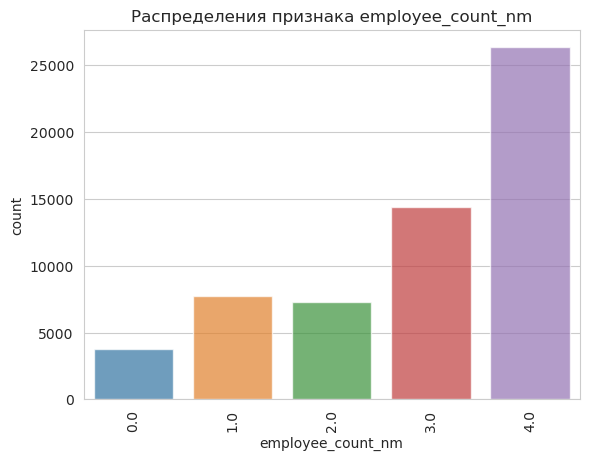

In [83]:
sns.countplot(data=clients_upd_df, x='employee_count_nm', alpha=0.7)
plt.xticks(rotation=90) 
plt.title('Распределения признака employee_count_nm');

In [84]:
cl_upd_df_per = clients_upd_df.groupby('employee_count_nm').customer_age.value_counts(normalize=True).mul(100).rename('percent_age').reset_index()
cl_upd_df_per

,employee_count_nm,customer_age,percent_age
0,0.0,1,28.364498
1,0.0,2,27.916776
2,0.0,3,26.415591
3,0.0,0,17.303134
4,1.0,3,28.125403
5,1.0,2,27.970584
6,1.0,1,26.164366
7,1.0,0,17.739646
8,2.0,3,32.184851
9,2.0,2,26.688543


In [85]:
cl_upd_df_per_for_plot = cl_upd_df_per.copy()
cl_upd_df_per_for_plot['customer_age'] = cl_upd_df_per_for_plot.customer_age.astype(str)
cl_upd_df_per_for_plot['employee_count_nm'] = cl_upd_df_per_for_plot.employee_count_nm.astype(str)

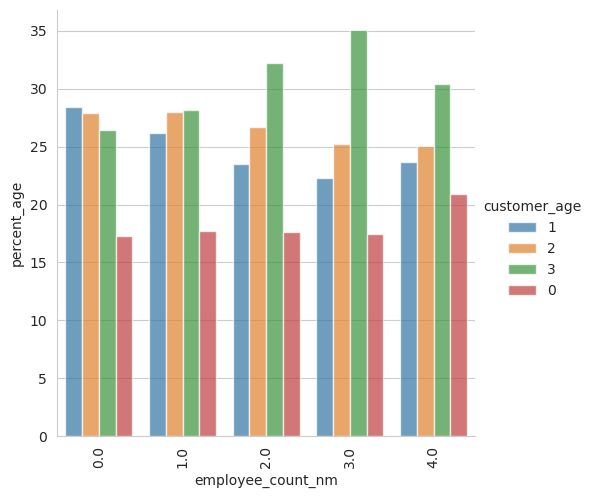

In [86]:
sns.catplot(data=cl_upd_df_per_for_plot, x='employee_count_nm', y='percent_age', hue='customer_age', kind='bar', alpha=0.7)
plt.xticks(rotation=90); 

можно заметить, что преобладание молодых клиентов наблюдается в маленьких компаниях (до 50ти человек), в то время как в крупных преимущественно работают более возрастные клиенты

In [87]:
cl_upd_df_per = clients_upd_df.groupby('customer_age').employee_count_nm.value_counts(normalize=True).mul(100).rename('percent_comp').reset_index()
cl_upd_df_per_for_plot = cl_upd_df_per.copy()
cl_upd_df_per_for_plot['customer_age'] = cl_upd_df_per_for_plot.customer_age.astype(str)
cl_upd_df_per_for_plot['employee_count_nm'] = cl_upd_df_per_for_plot.employee_count_nm.astype(str)
cl_upd_df_per

,customer_age,employee_count_nm,percent_comp
0,0,4.0,48.578241
1,0,3.0,22.112328
2,0,1.0,12.142353
3,0,2.0,11.365242
4,0,0.0,5.801837
5,1,4.0,43.689933
6,1,3.0,22.455279
7,1,1.0,14.226587
8,1,2.0,12.072957
9,1,0.0,7.555244


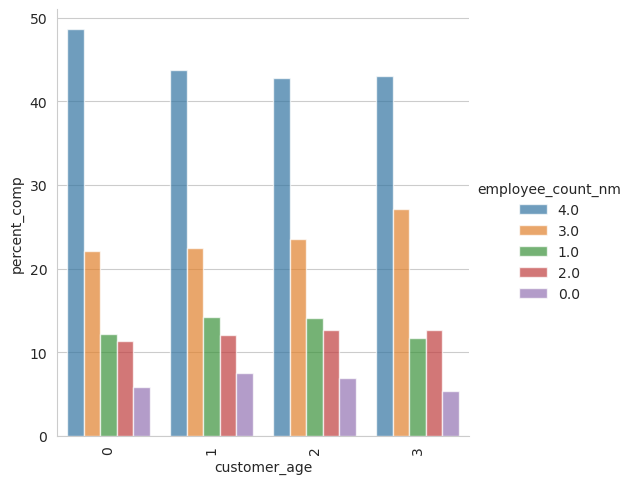

In [88]:
sns.catplot(data=cl_upd_df_per_for_plot, x='customer_age', y='percent_comp', hue='employee_count_nm', kind='bar', alpha=0.7)
plt.xticks(rotation=90); 

**Выводы:** К сожалению, несмотря на то, что в маленьких компаниях по возрасту сотрудники распределены более равномерно, за счет явного преобладания клиентов из крупных компаний, большинство молодых клиентов так же работают в них, поэтому мы не можем по возрасту предсказать разные категории компаний, заполнив тем самым пропуски в данных. Остаются несколько вариантов на пробу экспериментальным путем:
- удалить пропуски
- ввести признаки "от", "до" и заполнить их для пропусков значениями 0 и 1000, подкорректировав и имеющиеся значения

Вариант с заполнением самой популярной категорией - 4 - пробовать не будем, слишком много пропусков, данные исказятся

# Сбор и анализ тернировочного датасета

In [89]:
clients_upd_df

,user_id,report,employee_count_nm,bankemplstatus,customer_age,report_month,report_dt
0,3,2,3.0,0,3,8,2022-08-31 03:00:00
1,90,2,3.0,0,3,8,2022-08-31 03:00:00
2,146,2,2.0,0,2,8,2022-08-31 03:00:00
3,275,2,3.0,0,2,8,2022-08-31 03:00:00
4,572,2,NaN,0,2,8,2022-08-31 03:00:00
...,...,...,...,...,...,...,...
95995,549144,7,NaN,0,2,1,2023-01-31 03:00:00
95996,549160,7,NaN,0,1,1,2023-01-31 03:00:00
95997,549328,7,NaN,0,2,1,2023-01-31 03:00:00
95998,549486,7,NaN,0,2,1,2023-01-31 03:00:00


In [90]:
columns_client = ['user_id', 'employee_count_nm', 'bankemplstatus', 'customer_age', 'report_month']


all_df = clients_upd_df[columns_client].set_index('user_id').join([trans_sum.set_index('user_id'), df_user_f1.set_index('user_id'), 
                                                                   df_user_f3.set_index('user_id'), df_user_f4.set_index('user_id'), 
                                                                   df_user_f5.set_index('user_id'), df_user_f6.set_index('user_id'), 
                                                                   df_user_f7.set_index('user_id'), df_user_f8.set_index('user_id'), 
                                                                   train_df.set_index('user_id')])
all_df.head()

,employee_count_nm,bankemplstatus,customer_age,report_month,log_sum_amt_abs_0,log_sum_amt_abs_1,log_sum_amt_abs_2,log_sum_amt_abs_3,number_different_mcc,number_different_date,days_between_last_and_trans,number_trans_rub,sum_diff_week_trans,frequency_zero_diff,sum_zero_num_trans_w,target,time
user_id,,,,,,,,,,,,,,,,,
3,3.0,0,3,8,0.000000,12.789712,0.0,0.0,4,8,18,1.000000,5.881132,0.692308,106.592128,0.0,77.0
90,3.0,0,3,8,0.000000,12.411051,0.0,0.0,29,90,19,1.000000,-7.374508,0.230769,45.009981,0.0,91.0
146,2.0,0,2,8,12.454808,13.530788,0.0,0.0,40,171,11,0.618524,-54.615184,0.000000,0.000000,0.0,91.0
275,3.0,0,2,8,11.463863,11.921354,0.0,0.0,4,16,18,0.520000,0.676131,0.423077,62.745221,0.0,82.0
572,NaN,0,2,8,0.000000,12.852874,0.0,0.0,34,133,11,1.000000,-35.215683,0.000000,0.000000,NaN,NaN


In [91]:
all_df.reset_index(inplace=True)

In [92]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96000 entries, 0 to 95999
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   user_id                      96000 non-null  int64  
 1   employee_count_nm            59534 non-null  float64
 2   bankemplstatus               96000 non-null  int64  
 3   customer_age                 96000 non-null  int64  
 4   report_month                 96000 non-null  int32  
 5   log_sum_amt_abs_0            96000 non-null  float64
 6   log_sum_amt_abs_1            96000 non-null  float64
 7   log_sum_amt_abs_2            96000 non-null  float64
 8   log_sum_amt_abs_3            96000 non-null  float64
 9   number_different_mcc         96000 non-null  int64  
 10  number_different_date        96000 non-null  int64  
 11  days_between_last_and_trans  96000 non-null  int64  
 12  number_trans_rub             95659 non-null  float64
 13  sum_diff_week_tr

Заметим, что пропущенные значения так же имеются для number_trans_rub, это связано с тем, что у некоторых клиентов транзакций с рублями не было вовсе, поэтому можно пропуски заполнить нулями

In [93]:
all_df['number_trans_rub'].fillna(0, inplace=True)

Посмотрим есть ли пропуски среди employee_count_nm для тестовой выборки

In [94]:
len(all_df[(all_df['target'].isna()) & (all_df['employee_count_nm'].isna())])

12243

**Выводы:** нам нельзя исключать строки с пустым признаком employee_count_nm, т.к. пропуском много и в тесте. Далее будем пробовать два варианта:
- замена одного признака employee_count_nm на два: от и до
- удаление всего признака из датафрейма

# Обработка пропусков в employee_count_nm

заменим один признак на два

In [95]:
all_df['min_employee_count'] = all_df['employee_count_nm']
all_df['max_employee_count'] = all_df['employee_count_nm']
all_df['min_employee_count'].fillna(all_df['employee_count_nm'].min(), inplace=True)
all_df['max_employee_count'].fillna(all_df['employee_count_nm'].max(), inplace=True)

all_df.drop('employee_count_nm', axis=1, inplace=True)

In [96]:
all_df.info()#.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96000 entries, 0 to 95999
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   user_id                      96000 non-null  int64  
 1   bankemplstatus               96000 non-null  int64  
 2   customer_age                 96000 non-null  int64  
 3   report_month                 96000 non-null  int32  
 4   log_sum_amt_abs_0            96000 non-null  float64
 5   log_sum_amt_abs_1            96000 non-null  float64
 6   log_sum_amt_abs_2            96000 non-null  float64
 7   log_sum_amt_abs_3            96000 non-null  float64
 8   number_different_mcc         96000 non-null  int64  
 9   number_different_date        96000 non-null  int64  
 10  days_between_last_and_trans  96000 non-null  int64  
 11  number_trans_rub             96000 non-null  float64
 12  sum_diff_week_trans          96000 non-null  float64
 13  frequency_zero_d

# Кодирование категориальных признаков

customer_age, report_month - посчитаем за категориальные, т.к. не факт, что их увеличение ведет всегда к увеличению либо всегда к уменьшению целевого времени. Кодирование можно применить сразу ко всему датафрейму, т.к. там по факту нет никакого обучения на тренировочной выборке

In [97]:
categorical_columns = ['customer_age', 'report_month']
encoder = OneHotEncoder(sparse_output=False)
#encoder = OneHotEncoder()
one_hot_encoded = encoder.fit_transform(all_df[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
all_df = pd.concat([all_df, one_hot_df], axis=1).drop(columns=categorical_columns)


# Моделирование

## Разделение выборки на train и test

In [98]:
Xy_train = all_df[~all_df.target.isna()]

Xy_pred = all_df[all_df.target.isna()]
#X_test = tr_df[[column for column in tr_df.columns if column not in (['target', 'time'])]]


In [99]:
X_pred = Xy_pred.drop(['target', 'time'], axis=1)

In [100]:
X = Xy_train.drop(['target'], axis=1)#.reset_index()
y = Xy_train[['target']]

сначала разобъем наши данные обучающие со стратификацией по target

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=SPLIT_TEST_SIZE,
                                                    random_state=RANDOM_STATE,
                                                   stratify = y)

In [102]:
print(((y_train == 1).sum()/len(y_train)).iloc[0])
print(((y_test == 1).sum()/len(y_test)).iloc[0])

0.0846484375
0.084609375


отлично! наши данные разбились равномерно по целевому target

Теперь модифицируем целевой признак под модели выживаемости - добавим временную метку

In [103]:
y_train['time'] = X_train['time']
X_train.drop('time', axis=1, inplace=True)

In [104]:
y_test['time'] = X_test['time']
X_test.drop('time', axis=1, inplace=True)

In [105]:
y_train.loc[:, 'target'] = y_train['target'].astype(bool)
aux_train = [(e1,e2) for e1,e2 in  np.array(y_train)]
y_train = np.array(aux_train, dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

y_test.loc[:, 'target'] = y_test['target'].astype(bool)
aux_test = [(e1,e2) for e1,e2 in  np.array(y_test)]
y_test = np.array(aux_test, dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

## Построение модели RandomSurvivalForest

In [106]:
rsf = RandomSurvivalForest(
    n_estimators=250, max_depth=8, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=RANDOM_STATE, 
    verbose=2, low_memory=True
)
rsf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 250
building tree 2 of 250
building tree 3 of 250
building tree 4 of 250
building tree 5 of 250
building tree 6 of 250
building tree 7 of 250
building tree 8 of 250
building tree 9 of 250
building tree 10 of 250
building tree 11 of 250
building tree 12 of 250
building tree 13 of 250
building tree 14 of 250
building tree 15 of 250
building tree 16 of 250
building tree 17 of 250
building tree 18 of 250
building tree 19 of 250
building tree 20 of 250
building tree 21 of 250
building tree 22 of 250
building tree 23 of 250
building tree 24 of 250
building tree 25 of 250
building tree 26 of 250
building tree 27 of 250
building tree 28 of 250
building tree 29 of 250
building tree 30 of 250
building tree 31 of 250
building tree 32 of 250
building tree 33 of 250
building tree 34 of 250
building tree 35 of 250
building tree 36 of 250
building tree 37 of 250


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.1min


building tree 38 of 250
building tree 39 of 250
building tree 40 of 250
building tree 41 of 250
building tree 42 of 250
building tree 43 of 250
building tree 44 of 250
building tree 45 of 250
building tree 46 of 250
building tree 47 of 250
building tree 48 of 250
building tree 49 of 250
building tree 50 of 250
building tree 51 of 250
building tree 52 of 250
building tree 53 of 250
building tree 54 of 250
building tree 55 of 250
building tree 56 of 250
building tree 57 of 250
building tree 58 of 250
building tree 59 of 250
building tree 60 of 250
building tree 61 of 250
building tree 62 of 250
building tree 63 of 250
building tree 64 of 250
building tree 65 of 250
building tree 66 of 250
building tree 67 of 250
building tree 68 of 250
building tree 69 of 250
building tree 70 of 250
building tree 71 of 250
building tree 72 of 250
building tree 73 of 250
building tree 74 of 250
building tree 75 of 250
building tree 76 of 250
building tree 77 of 250
building tree 78 of 250
building tree 79

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 17.2min


building tree 159 of 250
building tree 160 of 250
building tree 161 of 250
building tree 162 of 250
building tree 163 of 250
building tree 164 of 250
building tree 165 of 250
building tree 166 of 250
building tree 167 of 250
building tree 168 of 250
building tree 169 of 250
building tree 170 of 250
building tree 171 of 250
building tree 172 of 250
building tree 173 of 250
building tree 174 of 250
building tree 175 of 250
building tree 176 of 250
building tree 177 of 250
building tree 178 of 250
building tree 179 of 250
building tree 180 of 250
building tree 181 of 250
building tree 182 of 250
building tree 183 of 250
building tree 184 of 250
building tree 185 of 250
building tree 186 of 250
building tree 187 of 250
building tree 188 of 250
building tree 189 of 250
building tree 190 of 250
building tree 191 of 250
building tree 192 of 250
building tree 193 of 250
building tree 194 of 250
building tree 195 of 250
building tree 196 of 250
building tree 197 of 250
building tree 198 of 250


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 26.5min finished


RandomSurvivalForest(low_memory=True, max_depth=8, min_samples_leaf=15,
                     min_samples_split=10, n_estimators=250, n_jobs=-1,
                     random_state=100, verbose=2)

In [109]:
rsf.score(X_test, y_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.2s finished


0.7424734743429966

## Обучение на всех данных

In [120]:
y_all = y.copy()
y_all['time'] = X['time']
X_all = X.drop('time', axis=1)

y_all.loc[:, 'target'] = y_all['target'].astype(bool)
aux_all = [(e1,e2) for e1,e2 in  np.array(y_all)]
y_all = np.array(aux_all, dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

In [122]:
rsf_all = RandomSurvivalForest(
    n_estimators=250, max_depth=8, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=RANDOM_STATE, 
    verbose=2, low_memory=True
)
rsf_all.fit(X_all, y_all)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 250
building tree 2 of 250
building tree 3 of 250
building tree 4 of 250
building tree 5 of 250
building tree 6 of 250
building tree 7 of 250
building tree 8 of 250
building tree 9 of 250
building tree 10 of 250
building tree 11 of 250
building tree 12 of 250
building tree 13 of 250
building tree 14 of 250
building tree 15 of 250
building tree 16 of 250
building tree 17 of 250
building tree 18 of 250
building tree 19 of 250
building tree 20 of 250
building tree 21 of 250
building tree 22 of 250
building tree 23 of 250
building tree 24 of 250
building tree 25 of 250
building tree 26 of 250
building tree 27 of 250
building tree 28 of 250
building tree 29 of 250
building tree 30 of 250
building tree 31 of 250
building tree 32 of 250
building tree 33 of 250
building tree 34 of 250
building tree 35 of 250
building tree 36 of 250
building tree 37 of 250


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.1min


building tree 38 of 250
building tree 39 of 250
building tree 40 of 250
building tree 41 of 250
building tree 42 of 250
building tree 43 of 250
building tree 44 of 250
building tree 45 of 250
building tree 46 of 250
building tree 47 of 250
building tree 48 of 250
building tree 49 of 250
building tree 50 of 250
building tree 51 of 250
building tree 52 of 250
building tree 53 of 250
building tree 54 of 250
building tree 55 of 250
building tree 56 of 250
building tree 57 of 250
building tree 58 of 250
building tree 59 of 250
building tree 60 of 250
building tree 61 of 250
building tree 62 of 250
building tree 63 of 250
building tree 64 of 250
building tree 65 of 250
building tree 66 of 250
building tree 67 of 250
building tree 68 of 250
building tree 69 of 250
building tree 70 of 250
building tree 71 of 250
building tree 72 of 250
building tree 73 of 250
building tree 74 of 250
building tree 75 of 250
building tree 76 of 250
building tree 77 of 250
building tree 78 of 250
building tree 79

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 31.6min


building tree 159 of 250
building tree 160 of 250
building tree 161 of 250
building tree 162 of 250
building tree 163 of 250
building tree 164 of 250
building tree 165 of 250
building tree 166 of 250
building tree 167 of 250
building tree 168 of 250
building tree 169 of 250
building tree 170 of 250
building tree 171 of 250
building tree 172 of 250
building tree 173 of 250
building tree 174 of 250
building tree 175 of 250
building tree 176 of 250
building tree 177 of 250
building tree 178 of 250
building tree 179 of 250
building tree 180 of 250
building tree 181 of 250
building tree 182 of 250
building tree 183 of 250
building tree 184 of 250
building tree 185 of 250
building tree 186 of 250
building tree 187 of 250
building tree 188 of 250
building tree 189 of 250
building tree 190 of 250
building tree 191 of 250
building tree 192 of 250
building tree 193 of 250
building tree 194 of 250
building tree 195 of 250
building tree 196 of 250
building tree 197 of 250
building tree 198 of 250


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 48.5min finished


RandomSurvivalForest(low_memory=True, max_depth=8, min_samples_leaf=15,
                     min_samples_split=10, n_estimators=250, n_jobs=-1,
                     random_state=100, verbose=2)

## Решение

In [123]:
predictions = rsf_all.predict(X_pred)
predictions

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.2s finished


array([1.45812378, 1.70966765, 2.64266331, ..., 6.21648284, 7.37492684,
       4.84189797])

In [124]:
submit = X_pred[['user_id']].copy()
submit['predict'] = predictions
submit

,user_id,predict
4,572,1.458124
6,731,1.709668
8,777,2.642663
10,897,6.730512
15,1068,5.822002
...,...,...
95993,548882,5.717377
95994,549068,6.114056
95995,549144,6.216483
95998,549486,7.374927


In [125]:
submit.to_csv('submission.csv',index=False)